In [1]:
from keras.layers import Conv2D
from keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten
from keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.convolutional import UpSampling2D
import keras.backend as K
import tensorflow as tf

import os
import numpy as np
import PIL
from PIL import Image
#import cv2
import IPython.display
from IPython.display import clear_output
from datetime import datetime
#from dataloader import Data, TestData

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import load_img, img_to_array,array_to_img

In [3]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

In [4]:
import tensorflow as tf
import keras
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)
print("tf.keras.__version__ is:", keras.__version__)
#print("tfa.__version__ is:", tfa.__version__)

Num GPUs Available:  1
tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf
tf.keras.__version__ is: 2.3.1


In [5]:
TIME_INTERVALS = 2
SHOW_SUMMARY = True

INPUT_SHAPE = (256, 256, 3)
EPOCHS = 30
BATCH = 1

# 25% i.e 64 width size will be mask from both side
MASK_PERCENTAGE = .25

EPSILON = 1e-9
ALPHA = 0.0004

CHECKPOINT = "checkpoint/"
SAVED_IMAGES = "saved_images/"

In [6]:
def fetch_data(path):
    images = []
    for root,dirs,files in os.walk(path):
        for file in files:
            img = load_img(root + '/' + file)
            images.append(img_to_array(img))
            
    return images

In [7]:
path = 'processed'
images= fetch_data(path)
print(len(images))

4318


In [8]:
array_to_img(images[3122]).show()

In [8]:
def mask_width(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width * MASK_PERCENTAGE)
    mask = np.ones([height, new_width, 3])
    missing_x = img[:, :new_width]
    missing_y = img[:, width - new_width:]
    missing_part = np.concatenate((missing_x, missing_y), axis=1)
    image = image[:, :width - new_width]
    image = image[:, new_width:]
    return image, missing_part


def get_masked_images(images):
    mask_images = []
    missing_images = []
    for image in images:
        mask_image, missing_image = mask_width(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image)
    return np.array(mask_images), np.array(missing_images)


def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]
        y_image = g_image[:, width:]
        o_image = np.concatenate((x_image,o_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

In [29]:
a, b = get_masked_images([images[3121]])

In [30]:
print(a.shape,b.shape)

(1, 256, 128, 3) (1, 256, 128, 3)


After masking
	Original Image			 a 		 b


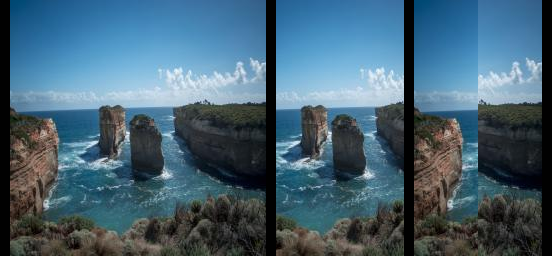

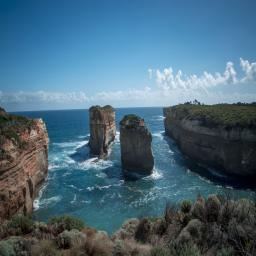

In [86]:
border = np.ones([images[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, images[3121],border,a[0],border, b[0], border), axis=1)
#IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
IPython.display.display(array_to_img(image))
#print("After desmasking: 'b/2' + a + 'b/2' ")
c = get_demask_images(a,b)
#IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(c[0], cv2.COLOR_BGR2RGB)))
IPython.display.display(array_to_img(c[0]))

In [9]:
images_train = images[:int(len(images) * 0.93)]
images_test = images[int(len(images) * 0.93):]

In [10]:
len(images_train)

4015

# DISCRIMINATOR

In [11]:
d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
d_dropout = 0.25
DCRM_OPTIMIZER = Adam(0.0001, 0.5)

In [ ]:
def d_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=d_dropout, norm=True):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = LeakyReLU(alpha=0.2)(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def build_discriminator():
    d_input = Input(shape=d_input_shape)
    d = d_build_conv(d_input, 32, 5,strides=2, norm=False)

    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    
    flat = Flatten()(d)
    fc1 = Dense(1024, activation='relu')(flat)
    d_output = Dense(1, activation='sigmoid')(fc1)
    
    return Model(d_input, d_output)

In [ ]:
DCRM = build_discriminator()
DCRM.compile(loss='mse', optimizer=DCRM_OPTIMIZER)
if SHOW_SUMMARY:
    DCRM.summary()

# GENERATOR

In [12]:
g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
g_dropout = 0.25
GEN_OPTIMIZER = Adam(0.001, 0.5)

In [ ]:

def g_build_conv(layer_input, filter_size, kernel= 4, strides=2, activation='leakyrelu', dropout_rate=g_dropout, norm='inst', dilation=1):
    c = Conv2D(filter_size, kernel_size=kernel, strides=strides, dilation_rate=(dilation,dilation), padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = LeakyReLU(alpha=0.2)(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def g_build_deconv(layer_input, filter_size, kernel_size=3, strides=2, activation='relu', dropout=0):
    d = Conv2DTranspose(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'relu':
        d = ReLU()(d)
    return d


def build_generator():
    g_input = Input(shape=g_input_shape)
    
    g1 = g_build_conv(layer_input = g_input, filter_size = 64, kernel = 5, strides=1, norm=False)
    g2 = g_build_conv(g1, 128, 4, strides=2)
    g3 = g_build_conv(g2, 128, 4, strides=2)

    g4 = g_build_conv(g3, 256, 4, strides=1)
    g5 = g_build_conv(g4, 512, 3, strides=1, dilation=2)
    g6 = g_build_conv(g5, 512, 3, strides=1, dilation=4)
    g7 = g_build_conv(g6, 512, 3, strides=1, dilation=8)
    g8 = g_build_conv(g7, 512, 3, strides=1, dilation=16)
    
    g9 = g_build_conv(g8, 256, 4, strides=1)
    g10 = g_build_deconv(g9, 128, 4, strides=2)
    g11 = g_build_deconv(g10, 128, 4, strides=2)
    g12 = g_build_conv(g11, 64, 4, strides=1)
    
    g_output = Conv2D(3, kernel_size=4, strides=(1,1), activation='tanh',padding='same', dilation_rate=(1,1))(g11)
    
    return Model(g_input, g_output)

In [ ]:
GEN = build_generator()
GEN.compile(loss='mse', optimizer=GEN_OPTIMIZER)
if SHOW_SUMMARY:
    GEN.summary()


In [ ]:
IMAGE = Input(shape=g_input_shape)
DCRM.trainable = False
GENERATED_IMAGE = GEN(IMAGE)
CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)

In [13]:
def save_model():
    global DCRM, GEN
    models = [DCRM, GEN]
    model_names = ['DCRM','GEN']

    for model, model_name in zip(models, model_names):
        model_path =  CHECKPOINT + "%s.json" % model_name
        weights_path = CHECKPOINT + "/%s.hdf5" % model_name
        options = {"file_arch": model_path, 
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    print("Saved Model")
    
    
def load_model():
    # Checking if all the model exists
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    for model_name in model_names:
        if model_name+".json" not in files or\
           model_name+".hdf5" not in files:
            print("Models not Found")
            return
    global DCRM, GEN, COMBINED, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
    
    # load DCRM Model
    model_path = CHECKPOINT + "%s.json" % 'DCRM'
    weight_path = CHECKPOINT + "%s.hdf5" % 'DCRM'
    with open(model_path, 'r') as f:
        DCRM = model_from_json(f.read())
    DCRM.load_weights(weight_path)
    DCRM.compile(loss='mse', optimizer=DCRM_OPTIMIZER)
    
    #load GEN Model
    model_path = CHECKPOINT + "%s.json" % 'GEN'
    weight_path = CHECKPOINT + "%s.hdf5" % 'GEN'
    with open(model_path, 'r') as f:
         GEN = model_from_json(f.read(), custom_objects={'InstanceNormalization': InstanceNormalization()})
    GEN.load_weights(weight_path)
    
    # Combined Model
    DCRM.trainable = False
    IMAGE = Input(shape=g_input_shape)
    GENERATED_IMAGE = GEN(IMAGE)
    CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

    COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
    COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)
    
    print("loaded model")

def save_image(epoch, steps, t_count):
    
    train_image = images_test[t_count]
        
    test_image = images_test[t_count+1]
    #if test_image is None:
     #   test_image = test_data.get_data(1)
    
    for nc, original in enumerate([train_image, test_image]):
        if nc:
            print("Predicting with train image")
        else:
            print("Predicting with test image")
            
        mask_image_original , missing_image = get_masked_images([original])
        mask_image = mask_image_original.copy()
        mask_image = mask_image / 127.5 - 1
        missing_image = missing_image / 127.5 - 1
        gen_missing = GEN.predict(mask_image)
        gen_missing = (gen_missing + 1) * 127.5
        gen_missing = gen_missing.astype(np.uint8)
        demask_image = get_demask_images(mask_image_original, gen_missing)

        mask_image = (mask_image + 1) * 127.5
        mask_image = mask_image.astype(np.uint8)

        border = np.ones([original[0].shape[0], 10, 3]).astype(np.uint8)

        file_name = SAVED_IMAGES + str(epoch) + "_" + str(steps) + ".jpg"
        final_image = np.concatenate((border, original,border,mask_image_original[0],border, demask_image[0], border), axis=1)
        final_image = array_to_img(final_image)
        if not nc:
        #    cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
            final_image.save(file_name)
        #final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        final_image = array_to_img(final_image)
        #print("\t1.Original image \t 2.Input \t\t 3. Output")
        IPython.display.display(final_image)
        print("image saved")


def save_log(log):
    with open('log.txt', 'a') as f:
        f.write("%s\n"%log)

In [14]:
def train():
    start_time = datetime.now()
    saved_time = start_time
    
    global MIN_D_LOSS, MIN_G_LOSS, CURRENT_D_LOSS, CURRENT_G_LOSS
    for epoch in range(4, EPOCHS):
        t_count = 0
        steps = 1
        test = None
        count = 0
        while True:
            if count >= len(images_train) - 1:
                break
            original = images_train[count: count+BATCH]
            original = np.asarray(original)
            if original is None:
                break
            batch_size = original.shape[0]
            count += BATCH
            mask_image, missing_image = get_masked_images(original)
            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1

            # Train Discriminator
            gen_missing = GEN.predict(mask_image)

            real = np.ones([batch_size, 1])
            fake = np.zeros([batch_size, 1])
            
            d_loss_original = DCRM.train_on_batch(missing_image, real)
            d_loss_mask = DCRM.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_original, d_loss_mask)

            # Train Generator
            for i in range(2):
                g_loss = COMBINED.train_on_batch(mask_image, [real, missing_image])
                    
            log = "epoch: %d, steps: %d, DIS loss: %s, GEN loss: %s, Identity loss: %s" \
                                            %(epoch, steps, str(d_loss), str(g_loss[0]), str(g_loss[2]))
            print(log)
            save_log(log)
            steps += 1
            
            # Save model if time taken > TIME_INTERVALS
            current_time = datetime.now()
            difference_time = current_time - saved_time
            if difference_time.seconds >= (TIME_INTERVALS * 60):
                save_model()
                save_image(epoch, steps, t_count)
                if t_count >= (len(images_test)-1):
                    t_count = 0
                else:
                    t_count += 1
                saved_time = current_time
        clear_output()

In [15]:
load_model()

loaded model


epoch: 5, steps: 1, DIS loss: 0.5, GEN loss: 1.1204183, Identity loss: 0.120418325
epoch: 5, steps: 2, DIS loss: 0.5, GEN loss: 1.0489281, Identity loss: 0.048928134
epoch: 5, steps: 3, DIS loss: 0.5, GEN loss: 1.1035285, Identity loss: 0.10352848
epoch: 5, steps: 4, DIS loss: 0.5, GEN loss: 1.0652906, Identity loss: 0.06529062
epoch: 5, steps: 5, DIS loss: 0.5, GEN loss: 1.1988634, Identity loss: 0.19886339
epoch: 5, steps: 6, DIS loss: 0.5, GEN loss: 1.0749676, Identity loss: 0.07496767
epoch: 5, steps: 7, DIS loss: 0.5, GEN loss: 1.0215055, Identity loss: 0.021505445
epoch: 5, steps: 8, DIS loss: 0.5, GEN loss: 1.0529256, Identity loss: 0.052925564
epoch: 5, steps: 9, DIS loss: 0.5, GEN loss: 1.0248312, Identity loss: 0.024831152
epoch: 5, steps: 10, DIS loss: 0.5, GEN loss: 1.0213287, Identity loss: 0.021328641
epoch: 5, steps: 11, DIS loss: 0.5, GEN loss: 1.0190078, Identity loss: 0.019007787
epoch: 5, steps: 12, DIS loss: 0.5, GEN loss: 1.1359663, Identity loss: 0.13596635
epoch:

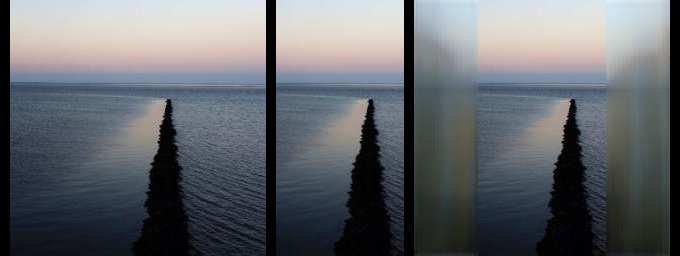

image saved
Predicting with train image


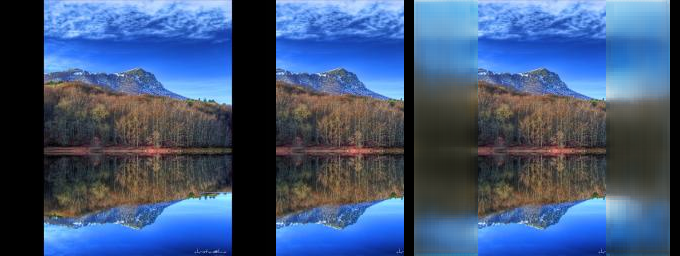

image saved
epoch: 5, steps: 15, DIS loss: 0.5, GEN loss: 1.1034034, Identity loss: 0.10340348
epoch: 5, steps: 16, DIS loss: 0.5, GEN loss: 1.1284262, Identity loss: 0.12842621
epoch: 5, steps: 17, DIS loss: 0.5, GEN loss: 1.0338917, Identity loss: 0.033891674
epoch: 5, steps: 18, DIS loss: 0.5, GEN loss: 1.0425516, Identity loss: 0.042551693
epoch: 5, steps: 19, DIS loss: 0.5, GEN loss: 1.0497218, Identity loss: 0.049721844
epoch: 5, steps: 20, DIS loss: 0.5, GEN loss: 1.0563159, Identity loss: 0.056315895
epoch: 5, steps: 21, DIS loss: 0.5, GEN loss: 1.066517, Identity loss: 0.066517025
epoch: 5, steps: 22, DIS loss: 0.5, GEN loss: 1.0821208, Identity loss: 0.08212075
epoch: 5, steps: 23, DIS loss: 0.5, GEN loss: 1.0697562, Identity loss: 0.06975616
epoch: 5, steps: 24, DIS loss: 0.5, GEN loss: 1.0567302, Identity loss: 0.056730133
epoch: 5, steps: 25, DIS loss: 0.5, GEN loss: 1.0195312, Identity loss: 0.019531252
epoch: 5, steps: 26, DIS loss: 0.5, GEN loss: 1.2501874, Identity los

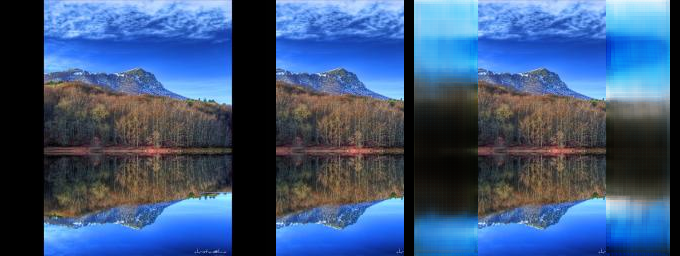

image saved
Predicting with train image


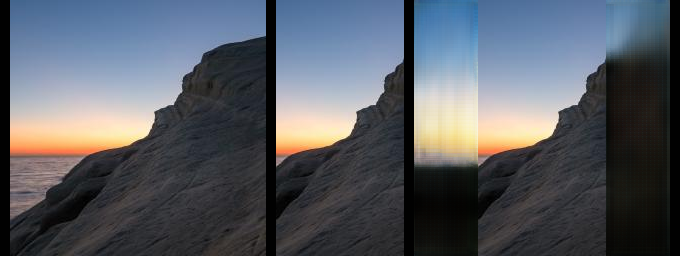

image saved
epoch: 5, steps: 69, DIS loss: 0.5, GEN loss: 1.0694419, Identity loss: 0.06944196
epoch: 5, steps: 70, DIS loss: 0.5, GEN loss: 1.1085246, Identity loss: 0.10852462
epoch: 5, steps: 71, DIS loss: 0.5, GEN loss: 1.0509696, Identity loss: 0.050969556
epoch: 5, steps: 72, DIS loss: 0.5, GEN loss: 1.0514077, Identity loss: 0.051407732
epoch: 5, steps: 73, DIS loss: 0.5, GEN loss: 1.0560973, Identity loss: 0.05609733
epoch: 5, steps: 74, DIS loss: 0.5, GEN loss: 1.0784713, Identity loss: 0.07847126
epoch: 5, steps: 75, DIS loss: 0.5, GEN loss: 1.0612226, Identity loss: 0.06122259
epoch: 5, steps: 76, DIS loss: 0.5, GEN loss: 1.0605383, Identity loss: 0.060538284
epoch: 5, steps: 77, DIS loss: 0.5, GEN loss: 1.0676806, Identity loss: 0.06768057
epoch: 5, steps: 78, DIS loss: 0.5, GEN loss: 1.1241556, Identity loss: 0.1241556
epoch: 5, steps: 79, DIS loss: 0.5, GEN loss: 1.0326071, Identity loss: 0.032607097
epoch: 5, steps: 80, DIS loss: 0.5, GEN loss: 1.0468049, Identity loss: 

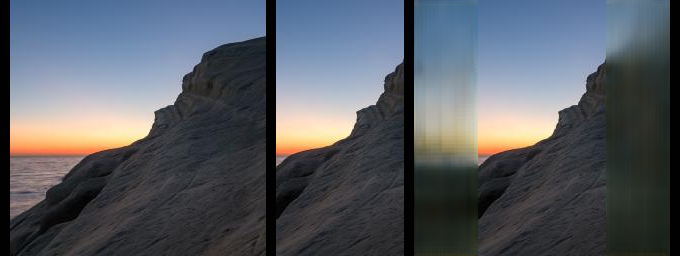

image saved
Predicting with train image


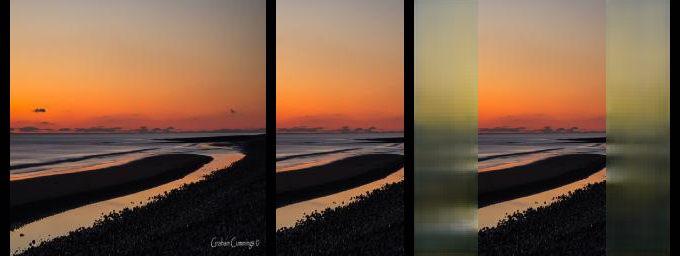

image saved
epoch: 5, steps: 123, DIS loss: 0.5, GEN loss: 1.0529746, Identity loss: 0.0529746
epoch: 5, steps: 124, DIS loss: 0.5, GEN loss: 1.0537719, Identity loss: 0.05377187
epoch: 5, steps: 125, DIS loss: 0.5, GEN loss: 1.1273335, Identity loss: 0.12733352
epoch: 5, steps: 126, DIS loss: 0.5, GEN loss: 1.0184531, Identity loss: 0.01845308
epoch: 5, steps: 127, DIS loss: 0.5, GEN loss: 1.107134, Identity loss: 0.10713398
epoch: 5, steps: 128, DIS loss: 0.5, GEN loss: 1.2100809, Identity loss: 0.21008083
epoch: 5, steps: 129, DIS loss: 0.5, GEN loss: 1.140087, Identity loss: 0.14008698
epoch: 5, steps: 130, DIS loss: 0.5, GEN loss: 1.0326769, Identity loss: 0.032676984
epoch: 5, steps: 131, DIS loss: 0.5, GEN loss: 1.0392718, Identity loss: 0.03927183
epoch: 5, steps: 132, DIS loss: 0.5, GEN loss: 1.1425449, Identity loss: 0.14254487
epoch: 5, steps: 133, DIS loss: 0.5, GEN loss: 1.1635495, Identity loss: 0.16354957
epoch: 5, steps: 134, DIS loss: 0.5, GEN loss: 1.0406731, Identity

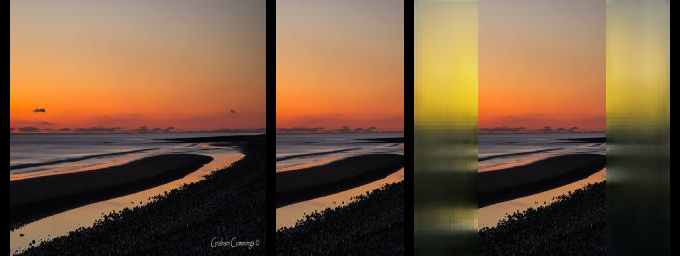

image saved
Predicting with train image


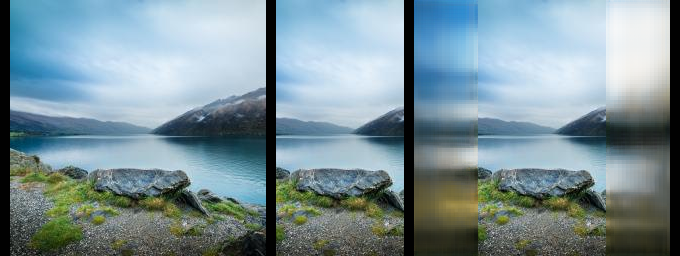

image saved
epoch: 5, steps: 177, DIS loss: 0.5, GEN loss: 1.0688705, Identity loss: 0.068870574
epoch: 5, steps: 178, DIS loss: 0.5, GEN loss: 1.0895139, Identity loss: 0.08951388
epoch: 5, steps: 179, DIS loss: 0.5, GEN loss: 1.0628055, Identity loss: 0.06280558
epoch: 5, steps: 180, DIS loss: 0.5, GEN loss: 1.1667192, Identity loss: 0.16671923
epoch: 5, steps: 181, DIS loss: 0.5, GEN loss: 1.0264208, Identity loss: 0.026420781
epoch: 5, steps: 182, DIS loss: 0.5, GEN loss: 1.2079766, Identity loss: 0.20797664
epoch: 5, steps: 183, DIS loss: 0.5, GEN loss: 1.0657251, Identity loss: 0.065725066
epoch: 5, steps: 184, DIS loss: 0.5, GEN loss: 1.0117229, Identity loss: 0.011722931
epoch: 5, steps: 185, DIS loss: 0.5, GEN loss: 1.0403736, Identity loss: 0.04037352
epoch: 5, steps: 186, DIS loss: 0.5, GEN loss: 1.0675023, Identity loss: 0.06750232
epoch: 5, steps: 187, DIS loss: 0.5, GEN loss: 1.0579636, Identity loss: 0.057963595
epoch: 5, steps: 188, DIS loss: 0.5, GEN loss: 1.0644548, I

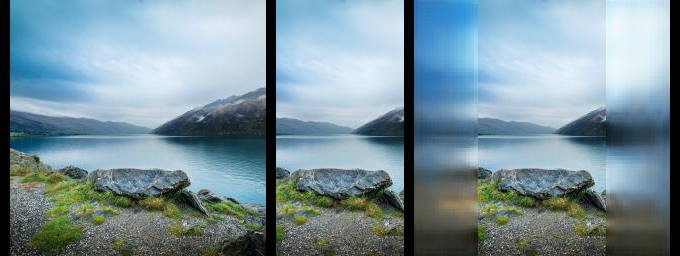

image saved
Predicting with train image


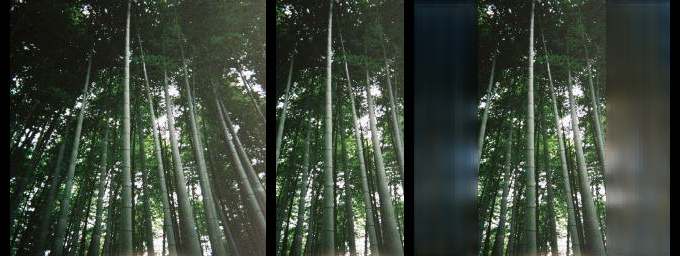

image saved
epoch: 5, steps: 231, DIS loss: 0.5, GEN loss: 1.1322633, Identity loss: 0.13226329
epoch: 5, steps: 232, DIS loss: 0.5, GEN loss: 1.09477, Identity loss: 0.094769955
epoch: 5, steps: 233, DIS loss: 0.5, GEN loss: 1.0398148, Identity loss: 0.039814856
epoch: 5, steps: 234, DIS loss: 0.5, GEN loss: 1.1428275, Identity loss: 0.14282757
epoch: 5, steps: 235, DIS loss: 0.5, GEN loss: 1.0428166, Identity loss: 0.0428167
epoch: 5, steps: 236, DIS loss: 0.5, GEN loss: 1.136568, Identity loss: 0.136568
epoch: 5, steps: 237, DIS loss: 0.5, GEN loss: 1.0142817, Identity loss: 0.014281732
epoch: 5, steps: 238, DIS loss: 0.5, GEN loss: 1.019821, Identity loss: 0.01982107
epoch: 5, steps: 239, DIS loss: 0.5, GEN loss: 1.1053994, Identity loss: 0.10539936
epoch: 5, steps: 240, DIS loss: 0.5, GEN loss: 1.0222701, Identity loss: 0.02227009
epoch: 5, steps: 241, DIS loss: 0.5, GEN loss: 1.1102622, Identity loss: 0.11026217
epoch: 5, steps: 242, DIS loss: 0.5, GEN loss: 1.0589137, Identity l

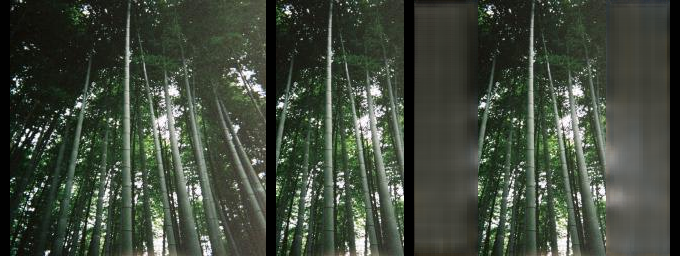

image saved
Predicting with train image


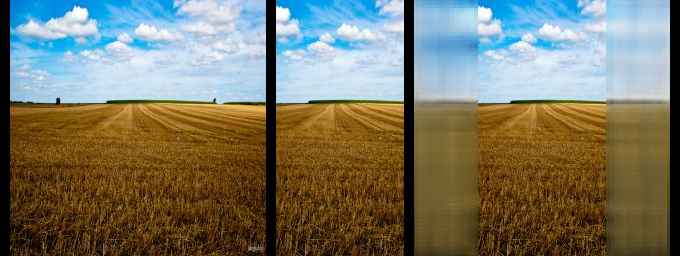

image saved
epoch: 5, steps: 285, DIS loss: 0.5, GEN loss: 1.0766126, Identity loss: 0.07661255
epoch: 5, steps: 286, DIS loss: 0.5, GEN loss: 1.0330017, Identity loss: 0.03300168
epoch: 5, steps: 287, DIS loss: 0.5, GEN loss: 1.1571157, Identity loss: 0.1571157
epoch: 5, steps: 288, DIS loss: 0.5, GEN loss: 1.087389, Identity loss: 0.087388985
epoch: 5, steps: 289, DIS loss: 0.5, GEN loss: 1.0350684, Identity loss: 0.035068408
epoch: 5, steps: 290, DIS loss: 0.5, GEN loss: 1.0490443, Identity loss: 0.04904427
epoch: 5, steps: 291, DIS loss: 0.5, GEN loss: 1.0481173, Identity loss: 0.048117302
epoch: 5, steps: 292, DIS loss: 0.5, GEN loss: 1.0498382, Identity loss: 0.04983813
epoch: 5, steps: 293, DIS loss: 0.5, GEN loss: 1.0384604, Identity loss: 0.038460415
epoch: 5, steps: 294, DIS loss: 0.5, GEN loss: 1.0564282, Identity loss: 0.056428194
epoch: 5, steps: 295, DIS loss: 0.5, GEN loss: 1.0908153, Identity loss: 0.09081531
epoch: 5, steps: 296, DIS loss: 0.5, GEN loss: 1.1471756, Ide

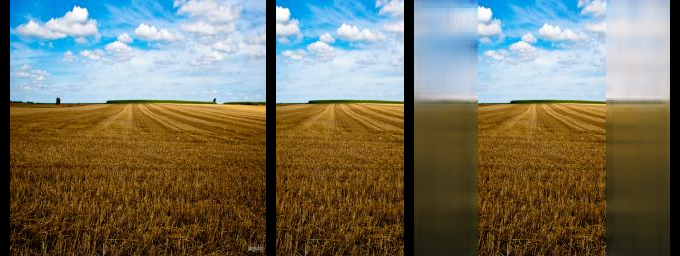

image saved
Predicting with train image


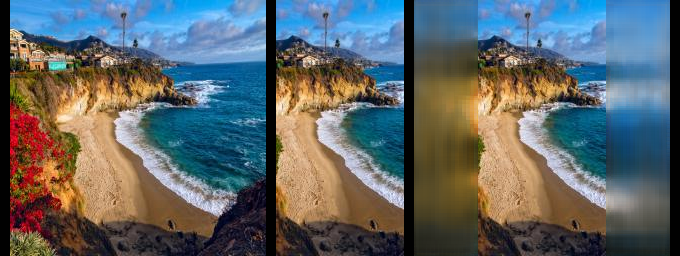

image saved
epoch: 5, steps: 339, DIS loss: 0.5, GEN loss: 1.1178904, Identity loss: 0.1178904
epoch: 5, steps: 340, DIS loss: 0.5, GEN loss: 1.0894377, Identity loss: 0.08943778
epoch: 5, steps: 341, DIS loss: 0.5, GEN loss: 1.1307652, Identity loss: 0.13076518
epoch: 5, steps: 342, DIS loss: 0.5, GEN loss: 1.0414382, Identity loss: 0.04143817
epoch: 5, steps: 343, DIS loss: 0.5, GEN loss: 1.0736266, Identity loss: 0.073626675
epoch: 5, steps: 344, DIS loss: 0.5, GEN loss: 1.0389401, Identity loss: 0.038940072
epoch: 5, steps: 345, DIS loss: 0.5, GEN loss: 1.0681652, Identity loss: 0.06816514
epoch: 5, steps: 346, DIS loss: 0.5, GEN loss: 1.1835504, Identity loss: 0.18355037
epoch: 5, steps: 347, DIS loss: 0.5, GEN loss: 1.1330897, Identity loss: 0.13308969
epoch: 5, steps: 348, DIS loss: 0.5, GEN loss: 1.162177, Identity loss: 0.16217697
epoch: 5, steps: 349, DIS loss: 0.5, GEN loss: 1.0653921, Identity loss: 0.06539211
epoch: 5, steps: 350, DIS loss: 0.5, GEN loss: 1.1714619, Identi

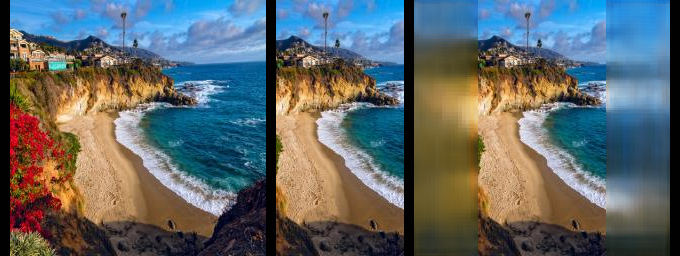

image saved
Predicting with train image


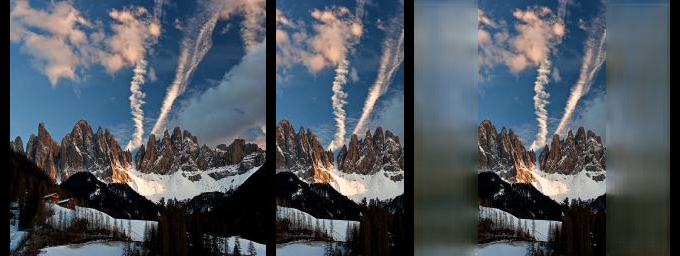

image saved
epoch: 5, steps: 393, DIS loss: 0.5, GEN loss: 1.1108757, Identity loss: 0.11087578
epoch: 5, steps: 394, DIS loss: 0.5, GEN loss: 1.1591504, Identity loss: 0.1591503
epoch: 5, steps: 395, DIS loss: 0.5, GEN loss: 1.0896611, Identity loss: 0.08966114
epoch: 5, steps: 396, DIS loss: 0.5, GEN loss: 1.1172099, Identity loss: 0.117209926
epoch: 5, steps: 397, DIS loss: 0.5, GEN loss: 1.0530256, Identity loss: 0.053025626
epoch: 5, steps: 398, DIS loss: 0.5, GEN loss: 1.043713, Identity loss: 0.04371295
epoch: 5, steps: 399, DIS loss: 0.5, GEN loss: 1.0372521, Identity loss: 0.037252113
epoch: 5, steps: 400, DIS loss: 0.5, GEN loss: 1.158671, Identity loss: 0.15867105
epoch: 5, steps: 401, DIS loss: 0.5, GEN loss: 1.1171441, Identity loss: 0.11714405
epoch: 5, steps: 402, DIS loss: 0.5, GEN loss: 1.0779147, Identity loss: 0.07791467
epoch: 5, steps: 403, DIS loss: 0.5, GEN loss: 1.1252967, Identity loss: 0.12529671
epoch: 5, steps: 404, DIS loss: 0.5, GEN loss: 1.0667099, Identi

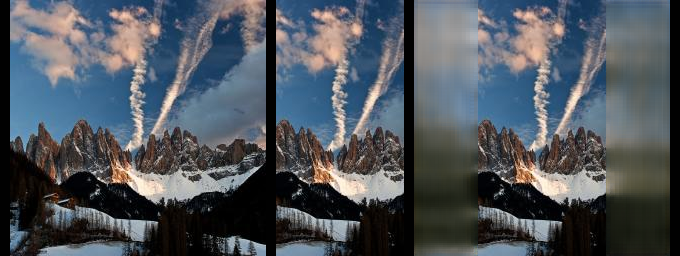

image saved
Predicting with train image


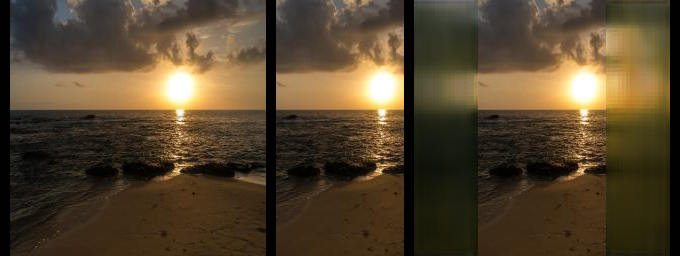

image saved
epoch: 5, steps: 447, DIS loss: 0.5, GEN loss: 1.0864116, Identity loss: 0.08641154
epoch: 5, steps: 448, DIS loss: 0.5, GEN loss: 1.0586004, Identity loss: 0.058600478
epoch: 5, steps: 449, DIS loss: 0.5, GEN loss: 1.0788484, Identity loss: 0.0788484
epoch: 5, steps: 450, DIS loss: 0.5, GEN loss: 1.0896068, Identity loss: 0.089606754
epoch: 5, steps: 451, DIS loss: 0.5, GEN loss: 1.0385143, Identity loss: 0.038514294
epoch: 5, steps: 452, DIS loss: 0.5, GEN loss: 1.0870575, Identity loss: 0.08705751
epoch: 5, steps: 453, DIS loss: 0.5, GEN loss: 1.0326743, Identity loss: 0.032674313
epoch: 5, steps: 454, DIS loss: 0.5, GEN loss: 1.0867345, Identity loss: 0.08673456
epoch: 5, steps: 455, DIS loss: 0.5, GEN loss: 1.1891133, Identity loss: 0.18911329
epoch: 5, steps: 456, DIS loss: 0.5, GEN loss: 1.1385804, Identity loss: 0.13858041
epoch: 5, steps: 457, DIS loss: 0.5, GEN loss: 1.0845, Identity loss: 0.08449994
epoch: 5, steps: 458, DIS loss: 0.5, GEN loss: 1.066556, Identit

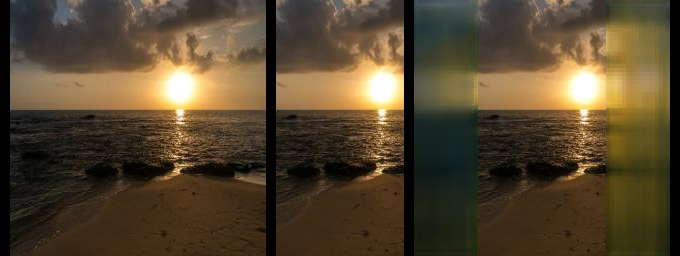

image saved
Predicting with train image


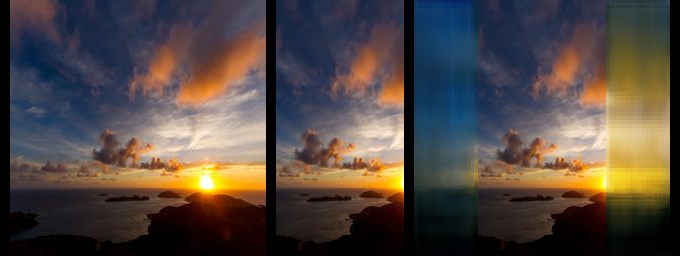

image saved
epoch: 5, steps: 501, DIS loss: 0.5, GEN loss: 1.1773152, Identity loss: 0.17731528
epoch: 5, steps: 502, DIS loss: 0.5, GEN loss: 1.1120298, Identity loss: 0.112029776
epoch: 5, steps: 503, DIS loss: 0.5, GEN loss: 1.0681978, Identity loss: 0.06819788
epoch: 5, steps: 504, DIS loss: 0.5, GEN loss: 1.0552908, Identity loss: 0.055290766
epoch: 5, steps: 505, DIS loss: 0.5, GEN loss: 1.1376516, Identity loss: 0.13765155
epoch: 5, steps: 506, DIS loss: 0.5, GEN loss: 1.124137, Identity loss: 0.12413699
epoch: 5, steps: 507, DIS loss: 0.5, GEN loss: 1.0393997, Identity loss: 0.039399736
epoch: 5, steps: 508, DIS loss: 0.5, GEN loss: 1.069998, Identity loss: 0.069997996
epoch: 5, steps: 509, DIS loss: 0.5, GEN loss: 1.1213931, Identity loss: 0.12139305
epoch: 5, steps: 510, DIS loss: 0.5, GEN loss: 1.1222146, Identity loss: 0.12221456
epoch: 5, steps: 511, DIS loss: 0.5, GEN loss: 1.1063249, Identity loss: 0.106324896
epoch: 5, steps: 512, DIS loss: 0.5, GEN loss: 1.0486522, Ide

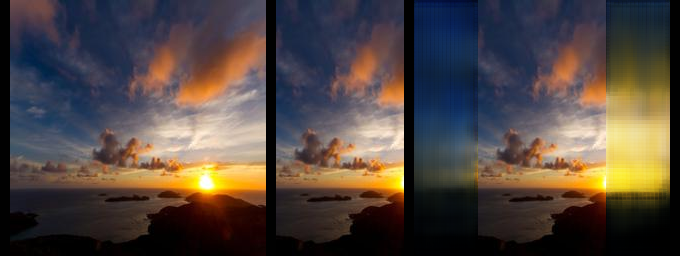

image saved
Predicting with train image


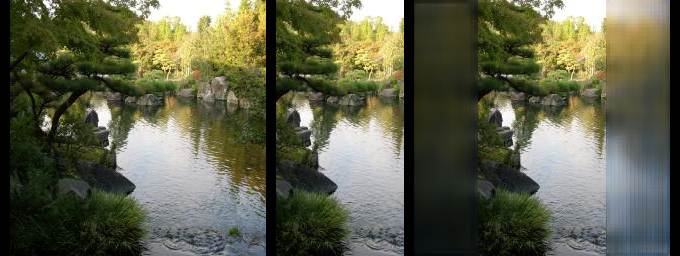

image saved
epoch: 5, steps: 555, DIS loss: 0.5, GEN loss: 1.0464761, Identity loss: 0.046476178
epoch: 5, steps: 556, DIS loss: 0.5, GEN loss: 1.0714859, Identity loss: 0.07148591
epoch: 5, steps: 557, DIS loss: 0.5, GEN loss: 1.204351, Identity loss: 0.20435092
epoch: 5, steps: 558, DIS loss: 0.5, GEN loss: 1.0840824, Identity loss: 0.084082425
epoch: 5, steps: 559, DIS loss: 0.5, GEN loss: 1.138569, Identity loss: 0.13856904
epoch: 5, steps: 560, DIS loss: 0.5, GEN loss: 1.0469457, Identity loss: 0.0469457
epoch: 5, steps: 561, DIS loss: 0.5, GEN loss: 1.0489888, Identity loss: 0.048988815
epoch: 5, steps: 562, DIS loss: 0.5, GEN loss: 1.0390185, Identity loss: 0.03901854
epoch: 5, steps: 563, DIS loss: 0.5, GEN loss: 1.1094747, Identity loss: 0.10947463
epoch: 5, steps: 564, DIS loss: 0.5, GEN loss: 1.0679909, Identity loss: 0.067990944
epoch: 5, steps: 565, DIS loss: 0.5, GEN loss: 1.090833, Identity loss: 0.09083295
epoch: 5, steps: 566, DIS loss: 0.5, GEN loss: 1.0996118, Identi

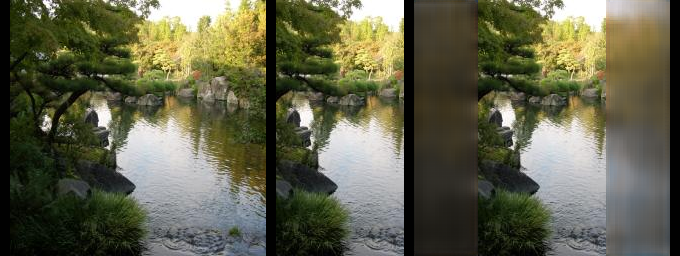

image saved
Predicting with train image


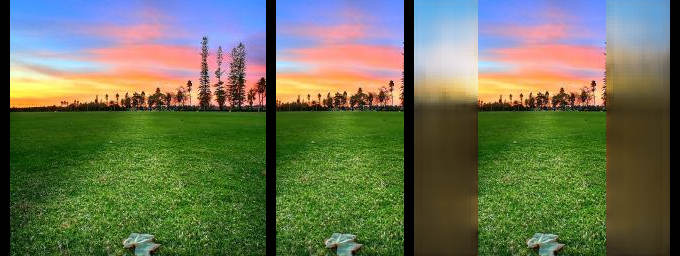

image saved
epoch: 5, steps: 609, DIS loss: 0.5, GEN loss: 1.0652865, Identity loss: 0.0652865
epoch: 5, steps: 610, DIS loss: 0.5, GEN loss: 1.0646262, Identity loss: 0.064626165
epoch: 5, steps: 611, DIS loss: 0.5, GEN loss: 1.0666206, Identity loss: 0.06662056
epoch: 5, steps: 612, DIS loss: 0.5, GEN loss: 1.0922203, Identity loss: 0.09222029
epoch: 5, steps: 613, DIS loss: 0.5, GEN loss: 1.0664495, Identity loss: 0.06644957
epoch: 5, steps: 614, DIS loss: 0.5, GEN loss: 1.1133056, Identity loss: 0.113305524
epoch: 5, steps: 615, DIS loss: 0.5, GEN loss: 1.0829856, Identity loss: 0.0829857
epoch: 5, steps: 616, DIS loss: 0.5, GEN loss: 1.0414294, Identity loss: 0.04142935
epoch: 5, steps: 617, DIS loss: 0.5, GEN loss: 1.0334558, Identity loss: 0.033455826
epoch: 5, steps: 618, DIS loss: 0.5, GEN loss: 1.1040734, Identity loss: 0.104073405
epoch: 5, steps: 619, DIS loss: 0.5, GEN loss: 1.1538616, Identity loss: 0.15386166
epoch: 5, steps: 620, DIS loss: 0.5, GEN loss: 1.0525578, Iden

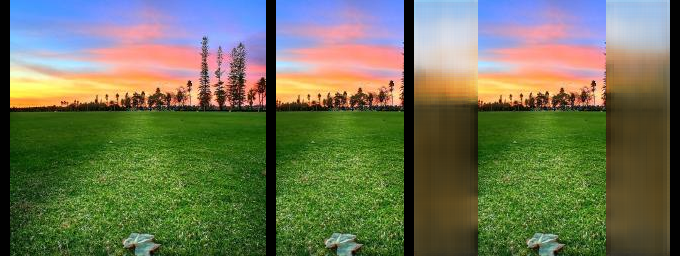

image saved
Predicting with train image


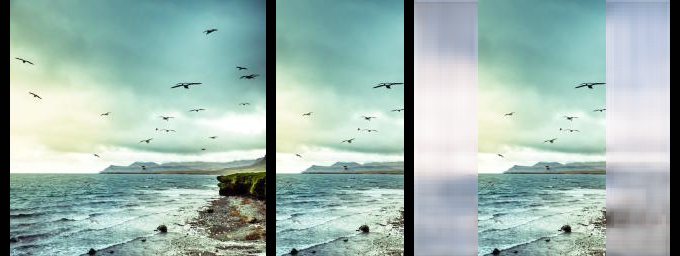

image saved
epoch: 5, steps: 663, DIS loss: 0.5, GEN loss: 1.0652461, Identity loss: 0.06524615
epoch: 5, steps: 664, DIS loss: 0.5, GEN loss: 1.0965776, Identity loss: 0.096577674
epoch: 5, steps: 665, DIS loss: 0.5, GEN loss: 1.2365589, Identity loss: 0.23655888
epoch: 5, steps: 666, DIS loss: 0.5, GEN loss: 1.1947372, Identity loss: 0.19473724
epoch: 5, steps: 667, DIS loss: 0.5, GEN loss: 1.0447606, Identity loss: 0.044760585
epoch: 5, steps: 668, DIS loss: 0.5, GEN loss: 1.0792891, Identity loss: 0.079289116
epoch: 5, steps: 669, DIS loss: 0.5, GEN loss: 1.0418872, Identity loss: 0.041887194
epoch: 5, steps: 670, DIS loss: 0.5, GEN loss: 1.099227, Identity loss: 0.099227
epoch: 5, steps: 671, DIS loss: 0.5, GEN loss: 1.0828962, Identity loss: 0.08289628
epoch: 5, steps: 672, DIS loss: 0.5, GEN loss: 1.0690749, Identity loss: 0.06907481


KeyboardInterrupt: 

In [16]:
train()